<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
   &#x1F335; Amirhossein Akbari  &#x1F335;
</div>

____

<font color=9999FF size=4>
&#x1F388; Full Name : Amir Malekhosseini
<br>
<font color=9999FF size=4>
&#x1F388; Student Number : 401100528

<font color=0080FF size=3>
This notebook explores word embeddings, compact and dense vector representations of words that capture their textual meaning. This notebook focusing on implementing the Word2Vec algorithm using the Skip-gram architecture and negative sampling.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from TensorFlow to assist with the implementation. However, PyTorch is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

<font color=#ffb578 size=3>
you are free to modify, add, or remove any cells as you see fit to complete your tasks. Feel free to change any of the provided code or content to better suit your understanding and approach to the problems.

- **Questions**: If you have any questions or require clarifications as you work through the notebook, please do not hesitate to ask. You can post your queries on Quera or reach out via Telegram.
- **Feedback**: We encourage you to seek feedback and engage in discussions to enhance your learning experience and improve your solutions.
</font>

In [1]:

import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [2]:

def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

[==================================================] 100.0% 31.6/31.6MB downloaded


### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

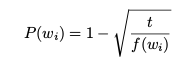

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [3]:
def preprocess_text(text_input):
    """
    Preprocesses text by removing punctuation, lowercasing,
    removing stop words, and filtering infrequent words.
    """
    import string
    from nltk.corpus import stopwords
    from collections import Counter
    import random

    # Remove punctuation
    translator = str.maketrans(string.punctuation, " " * len(string.punctuation))
    modified_text = text_input.translate(translator)

    # Lowercase and strip whitespace
    modified_text = modified_text.lower().strip()

    # Tokenize
    word_tokens = modified_text.split()

    # Remove stop words
    stopword_set = set(stopwords.words('english'))
    word_tokens = [word for word in word_tokens if word not in stopword_set]

    # Filter infrequent words (appearing less than 5 times)
    word_counts = Counter(word_tokens)
    word_tokens = [word for word in word_tokens if word_counts[word] >= 5]

    # Subsampling (downsampling frequent words) - directly in the loop
    threshold = 1e-5
    total_tokens = sum(word_counts.values())
    word_frequencies = {word: count / total_tokens for word, count in word_counts.items()}

    filtered_tokens = []
    for word in word_tokens:
        frequency = word_frequencies[word]
        probability_drop = 1 - (threshold / frequency)**0.5
        if random.random() > probability_drop:
            filtered_tokens.append(word)

    final_word_counts = Counter(filtered_tokens)

    return filtered_tokens, final_word_counts


In [4]:

processed_words, word_counts = preprocess_text(wiki)

It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [5]:

# Take a quick look at a slice of preprocessed words (e.g., index 1500 to 1550)
print(f"Processed words slice (1500-1550): {processed_words[1500:1550]}")
print(f"Word count (sample): {list(word_counts.items())[:5]}")

Processed words slice (1500-1550): ['hypocrisy', 'anarchism', 'anarchists', 'dismiss', 'prejudices', 'beliefs', 'day', 'anarchists', 'criticise', 'anarchist', 'proudhon', 'fascism', 'cercle', 'proudhon', 'anarcho', 'capitalist', 'bryan', 'caplan', 'treatment', 'fascists', 'fascist', 'sympathizers', 'illegitimate', 'anarchists', 'faction', 'communists', 'fascists', 'criticizes', 'willingness', 'cnt', 'statist', 'republican', 'civil', 'references', 'stanley', 'payne', 'regime', 'claims', 'cnt', 'entered', 'negotiations', 'noam', 'chomsky', 'kind', 'anarchism', 'popular', 'celebrities', 'publicly', 'identify', 'anarchists']
Word count (sample): [('originated', 268), ('abuse', 237), ('radicals', 114), ('including', 958), ('diggers', 25)]


### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [6]:
EMBEDDING_DIM = 300
BUFFER_SIZE = 10000
BATCH_SIZE = 512
EPOCHS = 5
WINDOW_SIZE = 3


### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams

# Initialize and fit tokenizer
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(processed_words)

# Generate sequences and vocabulary size
token_sequences = word_tokenizer.texts_to_sequences([processed_words])[0]
vocabulary_size = len(word_tokenizer.word_index) + 1  # +1 for the padding token

# Create skipgrams
skipgram_pairs, skipgram_labels = skipgrams(
    token_sequences,
    vocabulary_size=vocabulary_size,
    window_size=WINDOW_SIZE,
    negative_samples=1.0,
    shuffle=True
)

# Extract targets, contexts, and labels
target_words = np.array([pair[0] for pair in skipgram_pairs], dtype=np.int32)
context_words = np.array([pair[1] for pair in skipgram_pairs], dtype=np.int32)
skipgram_labels = np.array(skipgram_labels, dtype=np.int32)

train_data_size = int(len(target_words) * 0.8)

X_train_target = target_words[:train_data_size]
X_train_context = context_words[:train_data_size]
y_train = skipgram_labels[:train_data_size]

X_test_target = target_words[train_data_size:]
X_test_context = context_words[train_data_size:]
y_test = skipgram_labels[train_data_size:]


training_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_train_target, X_train_context), y_train)
)
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

testing_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_test_target, X_test_context), y_test)
)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [9]:
# Calculate the number of batches
num_training_batches = len(list(training_dataset))
num_testing_batches = len(list(testing_dataset))

# Print batch information
print(f"Training Batches: {num_training_batches}")
print(f"Testing Batches: {num_testing_batches}")

Training Batches: 48054
Testing Batches: 12014


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [10]:
import tensorflow as tf

class SkipGramModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        """
        Args:
            vocab_size   (int): Size of the vocabulary.
            embedding_dim(int): Dimension of the embedding vectors.
        """
        super(SkipGramModel, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=1,
            name="target_embedding"
        )

        self.context_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=1,
            name="context_embedding"
        )

    def call(self, inputs):
        """
        Defines the forward pass:
          inputs: tuple of (target_word, context_word)
        Returns:
          logits: raw predictions (logits) for binary classification (positive vs. negative)
        """

        target_word, context_word = inputs

        target_embeds = self.target_embedding(target_word)
        context_embeds = self.context_embedding(context_word)

        dot_product = tf.reduce_sum(target_embeds * context_embeds, axis=-1)
        return dot_product

### Loss function, Metrics and Optimizers

In [11]:
import tensorflow as tf

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.0, name="train_accuracy")
val_acc_metric   = tf.keras.metrics.BinaryAccuracy(threshold=0.0, name="val_accuracy")

### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [15]:

import time
import numpy as np

@tf.function
def train_step(model, optimizer, loss_fn, train_acc_metric, inputs, labels):

    with tf.GradientTape() as tape:
        predict = model(inputs)
        loss_value = loss_fn(labels, predict)

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update metrics
    train_acc_metric.update_state(labels, predict)

    return loss_value


@tf.function
def test_step(model, loss_fn, val_acc_metric, inputs, labels):

    predict = model(inputs)
    loss_value = loss_fn(labels, predict)

    # Update validation accuracy
    val_acc_metric.update_state(labels, predict)

    return loss_value


def train_model(
    model,
    training_data,
    validation_data,
    optimizer,
    loss_function,
    train_accuracy_metric,
    validation_accuracy_metric,
    num_epochs=5
):

    training_history = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        start_time = time.time()

        # Reset metrics for the epoch
        train_accuracy_metric.reset_state()
        epoch_train_loss = 0.0
        num_train_batches = 0

        # Training loop
        for step, ((target_words, context_words), labels) in enumerate(training_data):
            batch_loss = train_step(
                model=model,
                optimizer=optimizer,
                loss_fn=loss_function,
                train_acc_metric=train_accuracy_metric,
                inputs=(target_words, context_words),
                labels=labels
            )

            epoch_train_loss += batch_loss.numpy()
            num_train_batches += 1

            if step % 5000 == 0:
                print(f"  [Train Step {step}] Loss: {batch_loss.numpy():0.4f}")

        avg_train_loss = epoch_train_loss / num_train_batches
        train_accuracy = train_accuracy_metric.result().numpy()
        validation_accuracy_metric.reset_state()
        epoch_validation_loss = 0.0
        num_validation_batches = 0

        # Validation loop
        for (target_words, context_words), labels in validation_data:
            batch_loss = test_step(
                model=model,
                loss_fn=loss_function,
                val_acc_metric=validation_accuracy_metric,
                inputs=(target_words, context_words),
                labels=labels
            )

            epoch_validation_loss += batch_loss.numpy()
            num_validation_batches += 1

        avg_validation_loss = epoch_validation_loss / num_validation_batches
        validation_accuracy = validation_accuracy_metric.result().numpy()

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1} - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {avg_validation_loss:.4f}, Val Acc: {validation_accuracy:.4f}, "
              f"Time: {epoch_time:.2f}s")

        # Save history
        training_history.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_acc": train_accuracy,
            "val_loss": avg_validation_loss,
            "val_acc": validation_accuracy,
            "epoch_time": epoch_time
        })

    return training_history


In [16]:
# Initialize the SkipGram model
skipgram_model = SkipGramModel(vocabulary_size, EMBEDDING_DIM)

# Train the model
training_history = train_model(
    model=skipgram_model,
    training_data=training_dataset,
    validation_data=testing_dataset,
    optimizer=optimiser,
    loss_function=loss_fn,
    train_accuracy_metric=train_acc_metric,
    validation_accuracy_metric=val_acc_metric,
    num_epochs=EPOCHS
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/5
  [Train Step 0] Loss: 0.6935
  [Train Step 5000] Loss: 0.5242
  [Train Step 10000] Loss: 0.4948
  [Train Step 15000] Loss: 0.5048
  [Train Step 20000] Loss: 0.4493
  [Train Step 25000] Loss: 0.4469
  [Train Step 30000] Loss: 0.4415
  [Train Step 35000] Loss: 0.4625
  [Train Step 40000] Loss: 0.4714
  [Train Step 45000] Loss: 0.4568
Epoch 1 - Train Loss: 0.4929, Train Acc: 0.7751, Val Loss: 0.4465, Val Acc: 0.8085, Time: 1233.27s

Epoch 2/5
  [Train Step 0] Loss: 0.4664
  [Train Step 5000] Loss: 0.3620
  [Train Step 10000] Loss: 0.2898
  [Train Step 15000] Loss: 0.3035
  [Train Step 20000] Loss: 0.2989
  [Train Step 25000] Loss: 0.3095
  [Train Step 30000] Loss: 0.2773
  [Train Step 35000] Loss: 0.2642
  [Train Step 40000] Loss: 0.2981
  [Train Step 45000] Loss: 0.2535
Epoch 2 - Train Loss: 0.2964, Train Acc: 0.8774, Val Loss: 0.4990, Val Acc: 0.8010, Time: 1222.65s

Epoch 3/5
  [Train Step 0] Loss: 0.2110
  [Train Step 5000] Loss: 0.1971
  [Train Step 10000] Loss: 0.1892
  

In [17]:
# Create a checkpoint object
model_checkpoint = tf.train.Checkpoint(model=skipgram_model)

# Save the model weights
model_checkpoint.save("./skipgram_model_checkpoint")

# Print confirmation
print("Model weights saved to checkpoint.")

Model weights saved to checkpoint.


### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.
<font color=#ffb578>
6.Save the visualization of a word that best demonstrate the quality of your embeddings as an image and store it near the notebook.
7. Compress the folder into a `.zip` file and submit it as part of your work.

</font>


In [18]:
import numpy as np
import io

# Get target embeddings and word index
target_embeddings = skipgram_model.target_embedding.get_weights()[0]
word_to_index = word_tokenizer.word_index

# Get vocabulary size and embedding dimensions
vocabulary_size, embedding_dimension = target_embeddings.shape

# Save embeddings and metadata to TSV files
with io.open("embeddings.tsv", 'w', encoding='utf-8') as embeddings_file, \
     io.open("metadata.tsv", 'w', encoding='utf-8') as metadata_file:

    for word, index in word_to_index.items():
        if index < vocabulary_size:
            embedding_vector = target_embeddings[index]
            embeddings_file.write('\t'.join(map(str, embedding_vector)) + "\n")
            metadata_file.write(word + "\n")

print("Embedding and metadata TSV files created successfully.")
# Print the shape of the target embeddings
print("Shape of target embeddings:", target_embeddings.shape)

Embedding and metadata TSV files created successfully.
Shape of target embeddings: (71141, 300)
